# Exploring signal files with coffea

In this notebook we explore how to make selections on our signal file and match the reconstructed objects (jets, electrons, muons, etc) to our generator level information (from the simulation).

We first download one file from a simulated signal dataset (Higgs to WW in the lepton-neutrino-quark-quark final state):

```
mkdir data/
scp -r cmslpc-sl7.fnal.gov:/eos/uscms/store/user/lpcdihiggsboost/cmantill/PFNano/2017_UL_ak15/GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8/RunIISummer19UL17Jun23-106X_mc2017_realistic_v6-v2/210623_225150/0000/nano_mc2017_1-130.root data/nano_mc2017_1-130.root
```

In [1]:
!mkdir data/
!scp -r cmslpc-sl7.fnal.gov:/eos/uscms/store/user/lpcdihiggsboost/cmantill/PFNano/2017_UL_ak15/GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8/RunIISummer19UL17Jun23-106X_mc2017_realistic_v6-v2/210623_225150/0000/nano_mc2017_1-130.root data/nano_mc2017_1-130.root

mkdir: cannot create directory ‘data/’: File exists
nano_mc2017_1-130.root                        100%  252MB  94.1MB/s   00:02    


Then, we import some libraries:

In [1]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import candidate, vector
import matplotlib.pyplot as plt
import numpy as np

# we suppress ROOT warnings where our input ROOT tree has duplicate branches - these are handled correctly.
import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")

And we open the file with the coffea `NanoEventsFactory`:

In [2]:
fname = "data/nano_mc2017_1-130.root"
events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema, entry_stop=10000).events()

In [3]:
len(events)       # we have 10k events

10000

In [4]:
events.MET.fields     # checking the fields (equivalent to keys for a dict object)

['MetUnclustEnUpDeltaX',
 'MetUnclustEnUpDeltaY',
 'covXX',
 'covXY',
 'covYY',
 'phi',
 'pt',
 'significance',
 'sumEt',
 'sumPtUnclustered',
 'fiducialGenPhi',
 'fiducialGenPt']

In [5]:
events.Muon.pt      # prints the pt of each muon in each event

<Array [[], [], [15.6], ... [3.38], [5.82]] type='10000 * var * float32[paramete...'>

In [6]:
ak.num(events.Muon)    # counts the number of muons in each event

<Array [0, 0, 1, 0, 0, 0, ... 0, 0, 1, 1, 1, 1] type='10000 * int64'>

In [7]:
ak.sum(ak.num(events.Muon))    # counts the number of muons in all events

4745

In [8]:
events.Muon.mediumId      # ID: "loose", "medium" and "tight" working points - this just means that you can choose 3 different values of the classifier

<Array [[], [], [True], ... [False], [True]] type='10000 * var * bool[parameters...'>

Now, let's define some requirements on the leptons:

In [9]:
# leptons
goodmuon = (
    (events.Muon.pt > 25)
    & (abs(events.Muon.eta) < 2.4)
    & events.Muon.mediumId
)
nmuons = ak.sum(goodmuon, axis=1)

lowptmuon = (
    (events.Muon.pt > 10)
    & (abs(events.Muon.eta) < 2.4)
    & events.Muon.looseId
)
nlowptmuons = ak.sum(lowptmuon, axis=1)
            
goodelectron = (
    (events.Electron.pt > 25)
    & (abs(events.Electron.eta) < 2.5)
    & (events.Electron.mvaFall17V2noIso_WP80)
)
nelectrons = ak.sum(goodelectron, axis=1)

lowptelectron = (
    (events.Electron.pt > 10)
    & (abs(events.Electron.eta) < 2.5)
    & (events.Electron.cutBased >= events.Electron.LOOSE)
)
nlowptelectrons = ak.sum(lowptelectron, axis=1)

# since events can have more than one lepton (e.g. one high-pT electron and another lower pT muon), 
# we concatenate electrons and muons in the same array and select the higher-pT lepton (with ak.firsts)
goodleptons = ak.concatenate([events.Muon[goodmuon], events.Electron[goodelectron]], axis=1)
candidatelep = ak.firsts(goodleptons[ak.argsort(goodleptons.pt)])

# when we concatenate we lose the vector properties, so let's build another vector for our candidate lepton
### maybe not needed?
candidatelep_p4 = ak.zip(
    {
        "pt": candidatelep.pt,
        "eta": candidatelep.eta,
        "phi": candidatelep.phi,
        "mass": candidatelep.mass,
        "charge": candidatelep.charge,
    },
    with_name="PtEtaPhiMCandidate",
    behavior=candidate.behavior,
)

In [10]:
candidatelep

<Array [Electron, None, None, ... None, None] type='10000 * ?union[muon, electron]'>

In [11]:
candidatelep[0]

Electron

In [12]:
candidatelep[0].pt

30.557140350341797

Now, let's take a simple look at the fat-jets (large radius jets). 

Here, we define a variable `jet_arbitration` which will be used later. This indicates how we order and select our jet. 

Usually we want the highest pT jet in the collection (`pT` arbitration). However, for our HWW signal, maybe it is useful to look at the jet closest to the lepton (`lep` arbitration) or at the jet closest to the missing energy in the event - representing the energy carried away by the neutrino (`met` arbitration).

In [13]:
fatjets = events.FatJet
ak.sum(ak.num(fatjets[fatjets.pt>20]))     # counts how many fat-jets we have of pt>20Gev

328

In [14]:
fatjets.pt

<Array [[], [], [], [], ... [], [], [], []] type='10000 * var * float32[paramete...'>

(array([117.,  56.,  31.,  16.,   5.,   3.,   2.,   0.,   0.,   1.]),
 array([170.125 , 219.3125, 268.5   , 317.6875, 366.875 , 416.0625,
        465.25  , 514.4375, 563.625 , 612.8125, 662.    ], dtype=float32),
 <BarContainer object of 10 artists>)

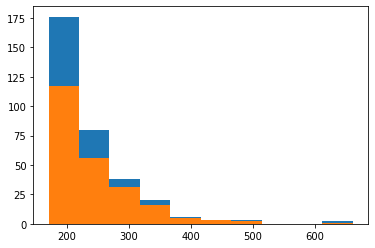

In [15]:
plt.hist(ak.flatten(fatjets.pt))     # flatten will use all jets in all events
plt.hist(ak.firsts(fatjets.pt))      # firsts will use all the first jets (highest pt) in all events

In [16]:
jet_arbitration = 'lep'

# let's define a collection of jets (with a pT threshold of 200 GeV)
fatjets = events.FatJet
candidatefj_temp = fatjets[fatjets.pt > 200]

# we take the Missing Transverse Energy MET from the event, and define the angular distance (delta_phi) of the MET with the jets
met = events.MET
dphi_met_fj = abs(candidatefj_temp.delta_phi(met))

# here we define the angular distance (or maybe conical distance - in R) of the jets with the candidate lepton we chose above
dr_lep_fj = candidatefj_temp.delta_r(candidatelep_p4)

# then we take the first jet (in something: pT, dR. w lepton, dphi w. MET...)
# we make use of the function ak.argmin that returns the index of the object that satistifies the minimum value (could also use ak.argmax)
# once we get that index, we use it to select our candidate jet
# (keepDims = True helps to keep the arrays dimensions)
if jet_arbitration == 'pt':
    candidatefj = ak.firsts(candidatefj_temp)
elif jet_arbitration == 'met':
    candidatefj = ak.firsts(candidatefj_temp[ak.argmin(dphi_met_fj,axis=1,keepdims=True)])
elif jet_arbitration == 'lep':
    candidatefj = ak.firsts(candidatefj_temp[ak.argmin(dr_lep_fj,axis=1,keepdims=True)])
else:
    raise RuntimeError("Unknown candidate jet arbitration")

In [17]:
dtype = type(candidatefj[107])     # just cz i know that 107 is of type FatJet (not None) for this particular pt>200 selection criterion

count = 0
for i in range(len(candidatefj)):
    if isinstance(candidatefj[i], dtype):
        count = count + 1
print("Number of fatjets with the pt selection criterion are: ", count)        

Number of fatjets with the pt selection criterion are:  70


Note, that some of these variables will be `None` for many events, i.e. what if an event does not have jets with high pT (which happens a lot in this dataset) or if an event does not have any leptons inside.

To track that we are doing the correct thing we can take a look at one event by selecting that event in brackets (events are always in the first axis of an array), i.e.:

In [18]:
# first we print the fatjets pt (note that here is the whole collection)
fatjets.pt

<Array [[], [], [], [], ... [], [], [], []] type='10000 * var * float32[paramete...'>

In [19]:
np.argwhere(ak.num(fatjets))[4]     # this is for the next part where we check that 107 is indeed an index of an event that contains fatjets (in fact 2 fatjets as shown in the next cell)

<Array [107] type='1 * int64'>

In [20]:
# you notice that for many of those events the array is empty..
# then we choose event 107 (which we know it has a fatjet - to see this you can just print the uproot tree above and see the columns)
evtid = 107
fatjets.pt[evtid]

<Array [238, 209] type='2 * float32[parameters={"__doc__": "pt"}]'>

In [21]:
# we have two fatjets apparently, now we can see which of those our jet arbitration chose:
candidatefj.pt[evtid]

237.875

In [22]:
# it seems to have chosen the jet with higher pT here
# let's print for curiosity the values of the dR of the lep and fatjets and the dPhi of the MET and fat jets
# note, that if we have two things to print we better use the print function
print(dphi_met_fj[evtid])
print(dr_lep_fj[evtid])

[1.95, 1.29]
[0.0691, 3.35]


In [23]:
dphi_met_fj[107]

<Array [1.95, 1.29] type='2 * float32'>

Now, let's play with another collection in the event, the `GenParticles`.
These can be obtained with the `events.GenPart` collection.
First, we need a function that will select given particles according to their particle ID (pdgID), or the flags of the process:

In [25]:
# this function will return us the particle objects that satisfy a low id, high id condition and have certain flags
def getParticles(genparticles,lowid=22,highid=25,flags=['fromHardProcess', 'isLastCopy']):
    absid = abs(genparticles.pdgId)
    return genparticles[
        ((absid >= lowid) & (absid <= highid))
        & genparticles.hasFlags(flags)
    ]

In [26]:
# first let's get all the higgs bosons in the event (pdgID=25)
higgs = getParticles(events.GenPart,25)

# make a mask to select all Higgs bosons that decay into Ws (pdgID=24) by looking at the children.pdgId
is_hWW = ak.all(abs(higgs.children.pdgId)==24,axis=2)

# now let's select our higgs to be all WW decays
higgs = higgs[is_hWW]

# now let's save it's children
# we will have two Ws as children. One will have higher mass than the other 
# the offshell W (also called W star) will have lower mass (~ 40 GeV max.) than the nominal W mass (80 GeV)
# thus, we can use argmin and argmax to select the Wstar and W candidates, respectively
higgs_wstar = higgs.children[ak.argmin(higgs.children.mass,axis=2,keepdims=True)]
higgs_w = higgs.children[ak.argmax(higgs.children.mass,axis=2,keepdims=True)]

Now, let's look at the decays of the W and W star. We want 4 particles inside our final state: a lepton, a neutrino, and 2 quarks. To look for these particles we can use the `isPrompt` or `fromHardProcess` flags.

- The pdgIDs of the electron, muon and tau leptons are 11, 13 and 15 respectively.
- The pdgIDs of quarks (not the top quark) range from 0 to 5.
- We do not care too much about the neutrino for now since we know it will be there when we see a lepton from a W.

In [27]:
# first let's select our electrons, muons and taus
prompt_electron = getParticles(events.GenPart,11,11,['isPrompt','isLastCopy'])
prompt_muon = getParticles(events.GenPart,13,13,['isPrompt', 'isLastCopy'])
prompt_tau = getParticles(events.GenPart,15,15,['isPrompt', 'isLastCopy'])

# for our quarks, we care about choosing the quarks that not only are coming from a hard process (e.g. the WW decay)
# but also the ones whose parent is a W (pdgId=24), this avoids select quarks whose parent is a gluon 
# who also happened to be produced in association with the Higgs
prompt_q = getParticles(events.GenPart,0,5,['fromHardProcess', 'isLastCopy'])
prompt_q = prompt_q[abs(prompt_q.distinctParent.pdgId) == 24]

# now we count the number of gen particles 
# we can use ak.sum, which will sum the number of times a mask is True for an event, 
# thus we declare a mask e.g. `prompt_electron.pt>0` and select along the inner axis (axis=1)
n_electrons = ak.sum(prompt_electron.pt>0,axis=1)
n_muons = ak.sum(prompt_muon.pt>0,axis=1)
n_taus = ak.sum(prompt_tau.pt>0,axis=1)
n_quarks = ak.sum(prompt_q.pt>0,axis=1)

We can take a look at what these variables look like for our event:

In [28]:
print('n electrons ',n_electrons[evtid])
print('n muons ',n_muons[evtid])
print('n taus ',n_taus[evtid])
print('n quarks ',n_quarks[evtid])

n electrons  0
n muons  1
n taus  0
n quarks  2


Looks like this event is a muon-neutrino-2quark final state. 
We can try to see what are the masses of the Ws that are parents of the prompt quarks.
Later we will want to use that information to see if the lepton is coming from a W (that tends to have more energy) or an offshell W (W star, that tends to be of lower energy.

In [29]:
# we will pick the parent of the quarks
print(prompt_q.distinctParent.mass)
# for some strange reason, the mass is duplicated so let's just pick the first of these ([:,0])
print(prompt_q.distinctParent.mass[:,0])

# then we take a look at the mass, and see if this array is the same as the W mass or as the W star mass arrays
print(prompt_q.distinctParent.mass[:,0]==higgs_w.mass)
print(prompt_q.distinctParent.mass[:,0]==higgs_wstar.mass)

[[39.5, 39.5], [80, 80], [30.8, 30.8], ... [35.2, 35.2], [5.56, 5.56], [41.1, 41.1]]
[39.5, 80, 30.8, 39.9, 79, 84, 78.8, ... 80.2, 5.78, 81, 80.8, 35.2, 5.56, 41.1]
[[[False]], [[True]], [[False]], [[False, ... [[False]], [[False]], [[False]]]
[[[True]], [[False]], [[True]], [[True]], ... [False]], [[True]], [[True]], [[True]]]


If you are curious we can also try to explore how did our prompt quarks array looked before we chose a distinctParent:

In [30]:
print('all quarks ',getParticles(events.GenPart,0,5,['fromHardProcess', 'isLastCopy']).pdgId)
print('distinct Parents of all quarks ',getParticles(events.GenPart,0,5,['fromHardProcess', 'isLastCopy']).distinctParent.pdgId)

all quarks  [[4, -3, -2], [4, -3], [4, -1], [-3, 4], ... [3, -4], [4, -3, 1], [2, -1], [3, -4]]
distinct Parents of all quarks  [[24, 24, 21], [24, 24], [24, 24], [24, ... -24], [24, 24, 21], [24, 24], [-24, -24]]


You can see that for some events the parents of the quarks are gluons (pdgId=21), so this is what we are avoiding by placing that 2nd selection on the prompt quarks. Ok, let's move on.

Now we can try to define a variable that indicates to us what kind of decay does that event have:
- electron-neutrino-2quarks
- muon-neutrino-2quarks
- tau-neutrino-2quarks (note that taus can decay often to electrons and muons so that's something we will investigate in the future)

In [31]:
# we define the `flavor` of the Higgs decay
# - 4(elenuqq),
# - 6(munuqq),
# - 8(taunuqq)
hWWlepqq_flavor = (n_quarks==2)*1 + (n_electrons==1)*3 + (n_muons==1)*5 + (n_taus==1)*7

# let's concatenate all the daughters
daughters = ak.concatenate([prompt_q,prompt_tau,prompt_muon,prompt_electron],axis=1)
daughters_energy = ak.concatenate([prompt_q.energy,prompt_tau.energy,prompt_muon.energy,prompt_electron.energy],axis=1)
# again, when we concatenate we need to re-define the vector arrays
daughters_p4 = ak.zip(
    {
        "pt": daughters.pt,
        "eta": daughters.eta,
        "phi": daughters.phi,
        "energy": daughters_energy,
    },
    with_name="PtEtaPhiELorentzVector",
)

Now it is the time to `match` our generator level information with our jet and lepton information.
There are at least 3 objects we want our jet to be geometrically and kinematically matched too:
- the gen Higgs boson
- the gen W boson from the Higgs decay
- the gen W* (off-shell) boson from the Higgs decay

We can find objects nearest to the candidate jet with the `nearest` option
https://github.com/CoffeaTeam/coffea/blob/1157c537351511184cc2f582e4567e3d7ba0d7bb/coffea/nanoevents/methods/vector.py#L640

In [45]:
# since our jet has a cone size of 0.8, we use 0.8 as a dR threshold
matchedH = candidatefj.nearest(higgs, axis=1, threshold=0.8)
matchedW = candidatefj.nearest(higgs_w, axis=1, threshold=0.8)
matchedWstar = candidatefj.nearest(higgs_wstar, axis=1, threshold=0.8)

We can see how these conditions look and how many times they are true for our evtid:

In [46]:
print(ak.sum(matchedH.pt>0,axis=1)[evtid])
print(ak.sum(matchedW.pt>0,axis=1)[evtid])
print(ak.sum(matchedWstar.pt>0,axis=1)[evtid])
print(matchedH[evtid],matchedW[evtid],matchedWstar[evtid])

1
[1]
[1]
[GenParticle] [[GenParticle]] [[GenParticle]]


Our event seems to be near by (a 0.8 R distance) to the Higgs boson, the W and the W star.

Now, let's define a variable (similar to the decay flavor above) that will tell us what objects the jet is matched to:

In [47]:
# matched: 1 (H only), 4(W), 6(W star), 9(H, W and Wstar)
hWWlepqq_matched = (ak.sum(matchedH.pt>0,axis=1)==1)*1 + (ak.sum(ak.flatten(matchedW.pt>0,axis=2),axis=1)==1)*3 + (ak.sum(ak.flatten(matchedWstar.pt>0,axis=2),axis=1)==1)*5

Our event will have a matching variable equal to:

In [48]:
hWWlepqq_matched[evtid]

9

Note that here I had to flatten the W and W star arrays first since they had one level of nesting

In [49]:
print((matchedW.pt>0)[evtid])
print(ak.flatten(matchedW.pt>0,axis=2)[evtid])
print(ak.sum(ak.flatten(matchedW.pt>0,axis=2),axis=1)[evtid])

[[True]]
[True]
1


Finally, let's see if we can match not only the W bosons but also it's daughters:

In [50]:
# making dR with the daughters p4 is too complicated because they are missing the mass as a property
# so let's use the collections individually:
dr_fj_quarks = candidatefj.delta_r(prompt_q)
dr_fj_electrons = candidatefj.delta_r(prompt_electron)
dr_fj_muons = candidatefj.delta_r(prompt_muon)
dr_fj_taus = candidatefj.delta_r(prompt_tau)

# now let's concatenate these dRs
dr_daughters = ak.concatenate([dr_fj_quarks,dr_fj_electrons,dr_fj_muons,dr_fj_taus],axis=1)

Let's see how these arrays look for our event:

In [51]:
print('dr quarks ',dr_fj_quarks[evtid])
print('dr electrons ',dr_fj_electrons[evtid])
print('dr muons ',dr_fj_muons[evtid])
print('dr taus ',dr_fj_taus[evtid])
print('dr daus ',dr_daughters[evtid])
print('number of daus matched ',ak.sum(dr_daughters<0.8,axis=1)[evtid])

dr quarks  [0.689, 0.353]
dr electrons  []
dr muons  [0.0691]
dr taus  []
dr daus  [0.689, 0.353, 0.0691]
number of daus matched  3


Finally let's define a last matching condition indicating the number of visible daughters it is matched to:

In [39]:
hWWlepqq_nprongs = ak.sum(dr_daughters<0.8,axis=1)